A companhia farmacêutica Lusa_Med detém os direitos sobre dez projetos I&D, P1, …, P10, e pretende iniciá-los na tentativa de desenvolver novos medicamentos para o tratamento de dez tipos específicos de doenças. Cada projeto necessita de um coordenador distinto para o liderar e, atendendo à exigência dos projetos, cada coordenador só poderá liderar um só projeto. A Lusa_Med já selecionou dez cientistas seniores, C1, …, C10, e pretende saber como deve alocar os cientistas aos projetos. Para o efeito, a companhia elaborou uma tabela com a aptidão de cada cientista para liderar cada um dos projetos (medida na escala 0-100):

In [1]:
from __future__ import annotations

import numpy as np
from dataclasses import dataclass as dc
from copy import deepcopy as copy
from pandas import DataFrame

showLog = True
table = np.array([
    [ 70,  65,  55,  50,  90,  67,  80,  62, 100,  85],
    [ 74,  83,  54,  60, 100,  75,  50,  76,  82,  45],
    [ 71,  87,  66,  58,  74,  81,  48,  52, 100,  64],
    [ 50,  89,  78,  63,  51,  40,  48, 100,  68,  75],
    [100,  66,  83,  77,  54,  58,  93,  89,  53,  48],
    [ 80,  55,  70,  65,  94,  47,  60,  88,  73,  60],
    [ 87,  63,  90,  79,  47,  77,  90,  76,  85,  90],
    [ 67,  95, 100,  40,  70,  54,  70, 100,  65,  57],
    [ 90,  45,  88,  48,  65,  68,  80,  46,  71,  67],
    [ 67,  77,  50,  60, 100,  70,  80,  60,  65,  70]
])
table

array([[ 70,  65,  55,  50,  90,  67,  80,  62, 100,  85],
       [ 74,  83,  54,  60, 100,  75,  50,  76,  82,  45],
       [ 71,  87,  66,  58,  74,  81,  48,  52, 100,  64],
       [ 50,  89,  78,  63,  51,  40,  48, 100,  68,  75],
       [100,  66,  83,  77,  54,  58,  93,  89,  53,  48],
       [ 80,  55,  70,  65,  94,  47,  60,  88,  73,  60],
       [ 87,  63,  90,  79,  47,  77,  90,  76,  85,  90],
       [ 67,  95, 100,  40,  70,  54,  70, 100,  65,  57],
       [ 90,  45,  88,  48,  65,  68,  80,  46,  71,  67],
       [ 67,  77,  50,  60, 100,  70,  80,  60,  65,  70]])

a) Uma solução admissível é uma solução que satisfaz as condições presupostas do problema. Portanto para este problema, qualquer solução que admite cada cientista a cada projetos (sendo que há 10 cientistas e 10 projetos) será uma solução admissível.

b) Uma possível heurística contrutiva seria admitir como lider do projeto $i$ o cientista cujo número está associado, $i$, $i = [1 .. 10]$. Ou seja, $C_1$ será lider de $P_1$, $C_2$ de $P_2$, e assim sucessivamente. Esta heurística, embora produzindo uma solução admissível, não é interessante para a **Lusa_med**, sendo que é equivalente a uma heurística que escolhe os líderes de forma aleatória (sem reposição). Portanto, uma heurística construtiva alternativa seria alocar para o cientista $i$ o projeto em que este tem a sua melhor aptidão, entre as ainda não alocadas ainda, $i =[1 .. 10]$. Ou seja, $C_1 \rightarrow P_9$, $C_2 \rightarrow P_5$, e assim sucesivamente.

In [2]:
@dc
class Project:
    index: int
    aptidao: int
@dc
class Cientista:
    index: int
    aptidoes: np.ndarray[int]
    projetoAssociado: Project = None
    projetos: list[Project]   = None
    def __post_init__(self):
        self.projetos = [Project(i+1, apt) for i, apt in enumerate(self.aptidoes)]
    def __str__(self):
        if self.projetoAssociado is not None:
            return f"C_{self.index}: P_{self.projetoAssociado.index} (Aptidão de {self.projetoAssociado.aptidao})"
        else:
            return f"C_{self.index} sem projeto associado"
    def reset(self):
        self.projetoAssociado = None
    def __getitem__(self, ind):
        return self.projetos[ind-1]
@dc
class Cientistas:
    matrix: np.ndarray[int, int]
    cientistas: list[Cientista] = None #will be overwriten
    def __post_init__(self):
        self.cientistas = []
        for i, row in enumerate(self.matrix):
            self.cientistas.append(Cientista(i+1, row))
    def __getitem__(self, indexDoCientista: int, indexDaAptidao: int = None) -> Cientista:
        if indexDaAptidao is None: return self.cientistas[indexDoCientista - 1]
        else: return self.cientistas[indexDoCientista - 1].aptidoes[indexDaAptidao - 1]
    def get(self, indexDoCientista) -> Cientista:
        return self[indexDoCientista]
    def __str__(self, repres=False):
        ret = "Cientistas e os seus projetos associados: \n"
        for c in self.cientistas:
            ret += "  " + repr(c) if repres else str(c) + "\n"
        ret += f"  Soma das aptidões: {self.getSum()}"
        return ret
    def reset(self):
        self.__post_init__()
    def __iter__(self):
        return iter(self.cientistas)
    def getSum(self):
        return sum([cient.projetoAssociado.aptidao for cient in self.cientistas if cient.projetoAssociado is not None])
    @property
    def aptidaoTotal(self):
        return self.getSum()
    def __len__(self):
        return len(self.cientistas)
    def tradeProject(self, cientista1: int | Cientista, cientista2: int | Cientista):
        if type(cientista1) is int: cientista1 = self.get(cientista1)
        if type(cientista2) is int: cientista2 = self.get(cientista2)
        # standart trade isn't good because the projects cientist based, that is its aptidao is based on the cientist
        cient1ProjInd = cientista1.projetoAssociado.index
        cient2ProjInd = cientista2.projetoAssociado.index
        cientista1.projetoAssociado = cientista1[cient2ProjInd]
        cientista2.projetoAssociado = cientista2[cient1ProjInd]
    def __eq__(self, other):
        if len(self) != len(other): return False
        for i in range(len(self)+1):
            if self[i].projetoAssociado.index != other[i].projetoAssociado.index:
                return False
        return True
    def __repr__(self):
        return repr([i.projetoAssociado.index for i in self.cientistas])
def log(*args, **kwargs):
    if showLog:
        print(*args, **kwargs)
cientistas = Cientistas(table)
/print cientistas

Cientistas e os seus projetos associados: 
C_1 sem projeto associado
C_2 sem projeto associado
C_3 sem projeto associado
C_4 sem projeto associado
C_5 sem projeto associado
C_6 sem projeto associado
C_7 sem projeto associado
C_8 sem projeto associado
C_9 sem projeto associado
C_10 sem projeto associado
  Soma das aptidões: 0


In [3]:
# c)
cientistas.reset()
pool = list(range(1,11))
def getMax(cient) -> Project:
    log("Cientista", cient.index)
    log("  Pool:", pool)
    projetos = [cient[projInd] for projInd in pool]
    maxObj   = max(projetos, key=lambda proj: proj.aptidao)
    log("  Max:", maxObj)
    return maxObj
    
for i, cientista in enumerate(cientistas):
    maxApt = getMax(cientista)
    cientista.projetoAssociado = maxApt
    pool.remove(maxApt.index)

print(cientistas)

Cientista 1
  Pool: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Max: Project(index=9, aptidao=100)
Cientista 2
  Pool: [1, 2, 3, 4, 5, 6, 7, 8, 10]
  Max: Project(index=5, aptidao=100)
Cientista 3
  Pool: [1, 2, 3, 4, 6, 7, 8, 10]
  Max: Project(index=2, aptidao=87)
Cientista 4
  Pool: [1, 3, 4, 6, 7, 8, 10]
  Max: Project(index=8, aptidao=100)
Cientista 5
  Pool: [1, 3, 4, 6, 7, 10]
  Max: Project(index=1, aptidao=100)
Cientista 6
  Pool: [3, 4, 6, 7, 10]
  Max: Project(index=3, aptidao=70)
Cientista 7
  Pool: [4, 6, 7, 10]
  Max: Project(index=7, aptidao=90)
Cientista 8
  Pool: [4, 6, 10]
  Max: Project(index=10, aptidao=57)
Cientista 9
  Pool: [4, 6]
  Max: Project(index=6, aptidao=68)
Cientista 10
  Pool: [4]
  Max: Project(index=4, aptidao=60)
Cientistas e os seus projetos associados: 
C_1: P_9 (Aptidão de 100)
C_2: P_5 (Aptidão de 100)
C_3: P_2 (Aptidão de 87)
C_4: P_8 (Aptidão de 100)
C_5: P_1 (Aptidão de 100)
C_6: P_3 (Aptidão de 70)
C_7: P_7 (Aptidão de 90)
C_8: P_10 (Aptidão de 57)
C_9


```mermaid
flowchart
    C1 -->|100| P9
    C2 -->|100| P5
    C3 -->|87| P2
    C4 -->|100| P8
    C5 -->|100| P1
    C6 -->|70| P3
    C7 -->|90| P7
    C8 -->|57| P10
    C9 -->|68| P6
    C10 -->|60| P4
```

d) Uma estrutura de vizinhança para este problema pode ser definida como TODO

In [4]:
# d)
def getVizinhanca(cientistas: Cientistas) -> Vizinhanca:
    for i in range(1, len(cientistas)+1): # [1:11[
        for j in range(i+1, len(cientistas)+1): #]i:11[
            vizinho = copy(cientistas)
            vizinho.tradeProject(i, j)
            yield vizinho, {i, j}

e) Uma solução vizinha da apresentada na alínea c) é a seguinte:

```mermaid
flowchart
    C1 -->|90| P5
    C2 -->|82| P9
    C3 -->|87| P2
    C4 -->|100| P8
    C5 -->|100| P1
    C6 -->|70| P3
    C7 -->|90| P7
    C8 -->|57| P10
    C9 -->|68| P6
    C10 -->|60| P4
```

In [5]:
# e)
V = getVizinhanca(cientistas)
first = next(V)
print(first[0])

Cientistas e os seus projetos associados: 
C_1: P_5 (Aptidão de 90)
C_2: P_9 (Aptidão de 82)
C_3: P_2 (Aptidão de 87)
C_4: P_8 (Aptidão de 100)
C_5: P_1 (Aptidão de 100)
C_6: P_3 (Aptidão de 70)
C_7: P_7 (Aptidão de 90)
C_8: P_10 (Aptidão de 57)
C_9: P_6 (Aptidão de 68)
C_10: P_4 (Aptidão de 60)
  Soma das aptidões: 804


f) A lista tabu é uma lista de movimentos que o algoritmo tem que evitar em cada iteração, de forma a o algoritmo não ficar preso num máximo local não global. Esta lista começa vazia no início do algoritmo, aumentando o seu tamanho a cada iteração, até um máximo $t$.

A cada iteração, o algoritmo adiciona na lista tabu uma representação do movimento da solução anterior para o vizinho efetuado, e retira o movimento mais velho se esceder $t$, sendo $t$ considerada a dimensão da lista tabu, um parâmetro do algorítmo tabu, que representa a dimensão da lista tabu. Desta forma, o algorítmo será forçado a explorar vizinhos potencialmente piores, em vês de vizinhos previamente visitados, de forma a *sair* do máximo local e explorar outro máximo. $t \in \mathbb{N}_0$

Uma outra forma de interpretar o parâmetro é ele como *tempo de permanência*, ou seja, em quantas iterações vai o movimento ser restrito de ser válido. Este conceito equivale ao conceito anterior, sendo que uma dimensão de $t$ de lista tabu significa que o movimento $M_1$, adicionado na primeira iteração, irá saír da lista $t$ iterações depois, pois $t$ iterações esta será o movimento mais velho.

Um $t$ demasiado alto pode fazer com que o algoritmo não visite soluções que poderiam ser melhores (nos mesmos vizinhos mas por caminhos alternativos), e um demasiado baixo pode fazer que o algoritmo não saia do máximo local. Devido a esse facto, se o algoritmo não conseguir chegar ao mínimo de aptidão desejado serão tentados tempos diferentes. Para a primeira tentativa, $t = 4$

g) À lista tabu vai ser adicionado uma representação da diferença entre a solução anterior e o vizinho escolhido, independentemente do valor de aptidão da solução anterior. Aqui, vai ser escolhido representar a diferença com a troca do projeto que os cientistas fizeram, independentemente do projeto que trocaram. Ou seja, $\forall t > 0$,

In [6]:
tabu = []
tabu.append(first[1])
tabu

[{1, 2}]

ou
$$
\mathbf{T}_1 = \left\{ \mathbf{M}_1 \right\} = \left\{ C_1 \leftrightarrow C_2\right\}
$$
,onde $\mathbf{T}_i$ indica a lista tabu depois da iteração $i$, e $C_i \leftrightarrow C_j$ representa a troca dos projetos entre $C_i$ e $C_j$

h) Um movimento tabu é um movimento entre a solução atual da iteração e um vizinho que seria considerado inválido, porque este movimento estaria na lista tabu. Por exemplo, $\forall t > 0$, considerando o exemplo anterior, um movimento equivalente a $M_1$ (ou seja, um movimento que iria trocar apenas os projetos de $C_1$ e $C_2$), seria um movimento tabu.

In [7]:
# i)
#                                                                                    Melhor solucao    lista de solucoes     lista de movimentos    lista de tabus                
def TabuSearch(primeira: Cientistas, tempo_perm: int, max_iter: int, minApt: int) -> tuple[Cientistas, tuple[list[Cientistas], list[set[int]], list[list[set[int]]]]]:
    tabu = []
    globalBest = iterBest = copy(primeira)
    log("Primeira solução:")
    log(globalBest)
    # for debug 
    solucoes = []
    solucoes_movs = []
    tabus = []
    for i in range(max_iter):
        
        # escolher melhor vizinho que não esteja na lista tabu
        iterBest_Apt = 0
        
        for localVizinho in getVizinhanca(iterBest):
            if localVizinho[1] not in tabu and localVizinho[0].aptidaoTotal > iterBest_Apt:
                iterBest_Apt = localVizinho[0].aptidaoTotal
                iterBest, iterBest_mov = localVizinho
        solucoes.append(iterBest)
        solucoes_movs.append(iterBest_mov)
        log(f"Melhor vizinho encontrado na iteração {i+1}:")
        log(iterBest)
        
        
        # Critério de Aspiração
        if iterBest.aptidaoTotal > globalBest.aptidaoTotal: # excluive
            log("Critério de aspiração!")
            globalBest = copy(iterBest) # copy n deve ser preciso mas é melhor
        
        # add to tabu
        tabu.append(iterBest_mov)
        if len(tabu) > tempo_perm:
            tabu.pop(0)
        
        tabus.append(tabu.copy())
        
        # stop condition (iterações está no range já)
        if globalBest.aptidaoTotal >= minApt:
            log("Atingido valor mínimo de aptidão!")
            return globalBest
        
    log("Atingido número máximo de iterações!")
    return globalBest, (solucoes, solucoes_movs, tabus)
first = TabuSearch(cientistas, tempo_perm=4, max_iter=100, minApt=850)
print(first[0])

Primeira solução:
Cientistas e os seus projetos associados: 
C_1: P_9 (Aptidão de 100)
C_2: P_5 (Aptidão de 100)
C_3: P_2 (Aptidão de 87)
C_4: P_8 (Aptidão de 100)
C_5: P_1 (Aptidão de 100)
C_6: P_3 (Aptidão de 70)
C_7: P_7 (Aptidão de 90)
C_8: P_10 (Aptidão de 57)
C_9: P_6 (Aptidão de 68)
C_10: P_4 (Aptidão de 60)
  Soma das aptidões: 832
Melhor vizinho encontrado na iteração 1:
Cientistas e os seus projetos associados: 
C_1: P_9 (Aptidão de 100)
C_2: P_5 (Aptidão de 100)
C_3: P_2 (Aptidão de 87)
C_4: P_8 (Aptidão de 100)
C_5: P_1 (Aptidão de 100)
C_6: P_10 (Aptidão de 60)
C_7: P_7 (Aptidão de 90)
C_8: P_3 (Aptidão de 100)
C_9: P_6 (Aptidão de 68)
C_10: P_4 (Aptidão de 60)
  Soma das aptidões: 865
Critério de aspiração!
Atingido valor mínimo de aptidão!
C_10: P_4 (Aptidão de 60)


In [8]:
wo_min = TabuSearch(cientistas, tempo_perm=4, max_iter=100, minApt=10000)
print(wo_min[0])

Primeira solução:
Cientistas e os seus projetos associados: 
C_1: P_9 (Aptidão de 100)
C_2: P_5 (Aptidão de 100)
C_3: P_2 (Aptidão de 87)
C_4: P_8 (Aptidão de 100)
C_5: P_1 (Aptidão de 100)
C_6: P_3 (Aptidão de 70)
C_7: P_7 (Aptidão de 90)
C_8: P_10 (Aptidão de 57)
C_9: P_6 (Aptidão de 68)
C_10: P_4 (Aptidão de 60)
  Soma das aptidões: 832
Melhor vizinho encontrado na iteração 1:
Cientistas e os seus projetos associados: 
C_1: P_9 (Aptidão de 100)
C_2: P_5 (Aptidão de 100)
C_3: P_2 (Aptidão de 87)
C_4: P_8 (Aptidão de 100)
C_5: P_1 (Aptidão de 100)
C_6: P_10 (Aptidão de 60)
C_7: P_7 (Aptidão de 90)
C_8: P_3 (Aptidão de 100)
C_9: P_6 (Aptidão de 68)
C_10: P_4 (Aptidão de 60)
  Soma das aptidões: 865
Critério de aspiração!
Melhor vizinho encontrado na iteração 2:
Cientistas e os seus projetos associados: 
C_1: P_9 (Aptidão de 100)
C_2: P_5 (Aptidão de 100)
C_3: P_2 (Aptidão de 87)
C_4: P_8 (Aptidão de 100)
C_5: P_1 (Aptidão de 100)
C_6: P_4 (Aptidão de 65)
C_7: P_7 (Aptidão de 90)
C_8: P

In [9]:
df = DataFrame({
    "iteracao" : list(range(1,101)),
    "solucoes" : [repr(i) for i in wo_min[1][0]],
    "movimento": wo_min[1][1],
    "tabus"    : wo_min[1][2],
    "aptidao"  : [i.aptidaoTotal for i in wo_min[1][0]]
})
df.set_index("iteracao")

,solucoes,movimento,tabus,aptidao
iteracao,,,,
1,"[9, 5, 2, 8, 1, 10, 7, 3, 6, 4]","{8, 6}","[{8, 6}]",865
2,"[9, 5, 2, 8, 1, 4, 7, 3, 6, 10]","{10, 6}","[{8, 6}, {10, 6}]",880
3,"[9, 5, 2, 8, 1, 4, 10, 3, 6, 7]","{10, 7}","[{8, 6}, {10, 6}, {10, 7}]",890
4,"[9, 5, 2, 8, 1, 4, 10, 3, 7, 6]","{9, 10}","[{8, 6}, {10, 6}, {10, 7}, {9, 10}]",892
5,"[9, 6, 2, 8, 1, 4, 10, 3, 7, 5]","{2, 10}","[{10, 6}, {10, 7}, {9, 10}, {2, 10}]",897
...,...,...,...,...
96,"[9, 5, 2, 8, 1, 4, 10, 3, 7, 6]","{10, 3}","[{2, 3}, {9, 5}, {2, 10}, {10, 3}]",892
97,"[9, 5, 2, 8, 1, 4, 10, 3, 6, 7]","{9, 10}","[{9, 5}, {2, 10}, {10, 3}, {9, 10}]",890
98,"[9, 5, 2, 8, 4, 1, 10, 3, 6, 7]","{5, 6}","[{2, 10}, {10, 3}, {9, 10}, {5, 6}]",882


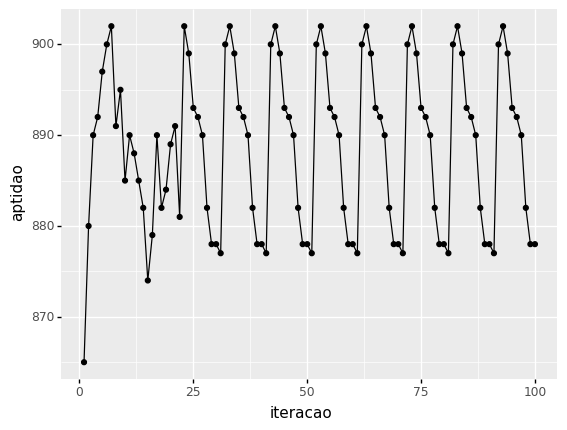

<ggplot: (-9223371953844180148)>

In [10]:
from plotnine import *
(ggplot(df, aes(x="iteracao", y="aptidao")) + geom_point() + geom_line())

Ciclo, TODO texto

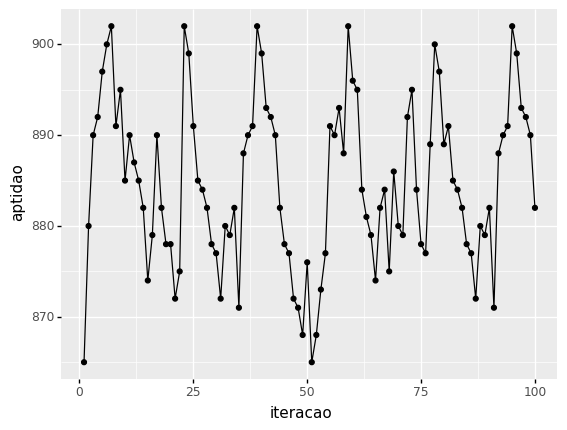

<ggplot: (-9223371953841785188)>

In [11]:
showLog = False
temp5 = TabuSearch(cientistas, tempo_perm=5, max_iter=100, minApt=10000)


df2 = DataFrame({
    "iteracao" : list(range(1,101)),
    "solucoes" : [repr(i) for i in temp5[1][0]],
    "movimento": temp5[1][1],
    "tabus"    : temp5[1][2],
    "aptidao"  : [i.aptidaoTotal for i in temp5[1][0]]
})


(ggplot(df2, aes(x="iteracao", y="aptidao")) + geom_point() + geom_line())

In [12]:
print(temp5[0])

Cientistas e os seus projetos associados: 
C_1: P_9 (Aptidão de 100)
C_2: P_2 (Aptidão de 83)
C_3: P_6 (Aptidão de 81)
C_4: P_8 (Aptidão de 100)
C_5: P_7 (Aptidão de 93)
C_6: P_4 (Aptidão de 65)
C_7: P_10 (Aptidão de 90)
C_8: P_3 (Aptidão de 100)
C_9: P_1 (Aptidão de 90)
C_10: P_5 (Aptidão de 100)
  Soma das aptidões: 902


Mais texto TODO